In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os

In [2]:
def calibrate_ou_params(df, dt=1 / 12):
    """
    Calibrates Ornstein-Uhlenbeck parameters (Theta, Mu, Sigma) from historical data.
    """
    df = df.sort_values('Date')
    prices = df['PX_LAST'].values
    # Regression: P(t+1) = a * P(t) + b
    x_t = prices[:-1].reshape(-1, 1)
    x_tp1 = prices[1:]
    model = LinearRegression()
    model.fit(x_t, x_tp1)
    a = model.coef_[0]
    b = model.intercept_
    # Residuals for volatility
    predictions = model.predict(x_t)
    residuals = x_tp1 - predictions
    std_resid = np.std(residuals, ddof=1)
    # Calculate Parameters
    theta = -np.log(a) / dt
    mu = b / (1 - a)
    if abs(1 - a ** 2) < 1e-8:
        sigma = std_resid / np.sqrt(dt)
    else:
        sigma = std_resid * np.sqrt((2 * theta) / (1 - a ** 2))
    return theta, mu, sigma

In [3]:
def simulate_log_ou_price(
        current_price,
        long_term_mean_price,
        reversion_speed,
        volatility_price,
        cheap_threshold,
        T=1.0,
        steps_per_year=52,
        simulations=10000,
        plot=True,
        title="Log-OU Price Simulation"
):
    np.random.seed(42)
    dt = 1 / steps_per_year
    N = int(T / dt)
    y0 = np.log(current_price)
    mu_log = np.log(long_term_mean_price)
    sigma = volatility_price / current_price
    Y = np.zeros((N + 1, simulations))
    Y[0] = y0
    # Euler-Maruyama Discretization
    for t in range(1, N + 1):
        dW = np.random.normal(0, np.sqrt(dt), simulations)
        Y[t] = (
                Y[t - 1]
                + reversion_speed * (mu_log - Y[t - 1]) * dt
                + sigma * dW
        )
    X = np.exp(Y)
    final_prices = X[-1]
    print(f"\n--- {title} ---")
    print(f"Current: {current_price:.2f} | Long-term Mean: {long_term_mean_price:.2f}")
    print(f"Forecast Mean (1yr): {np.mean(final_prices):.2f}")
    print(f"Prob < Threshold ({cheap_threshold:.2f}): {np.mean(final_prices < cheap_threshold):.2%}")
    if plot:
        t_grid = np.linspace(0, T, N + 1)
        mean_path = np.mean(X, axis=1)
        p5 = np.percentile(X, 5, axis=1)
        p95 = np.percentile(X, 95, axis=1)
        plt.figure(figsize=(10, 6))
        plt.plot(t_grid, X[:, :20], color="gray", alpha=0.1)
        plt.fill_between(t_grid, p5, p95, color="blue", alpha=0.25, label="90% Confidence Band")
        plt.plot(t_grid, mean_path, color="blue", lw=2.5, label="Expected Price")
        plt.axhline(long_term_mean_price, color="red", ls="--", label="Long-term Mean")
        plt.title(title)
        plt.xlabel("Years")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

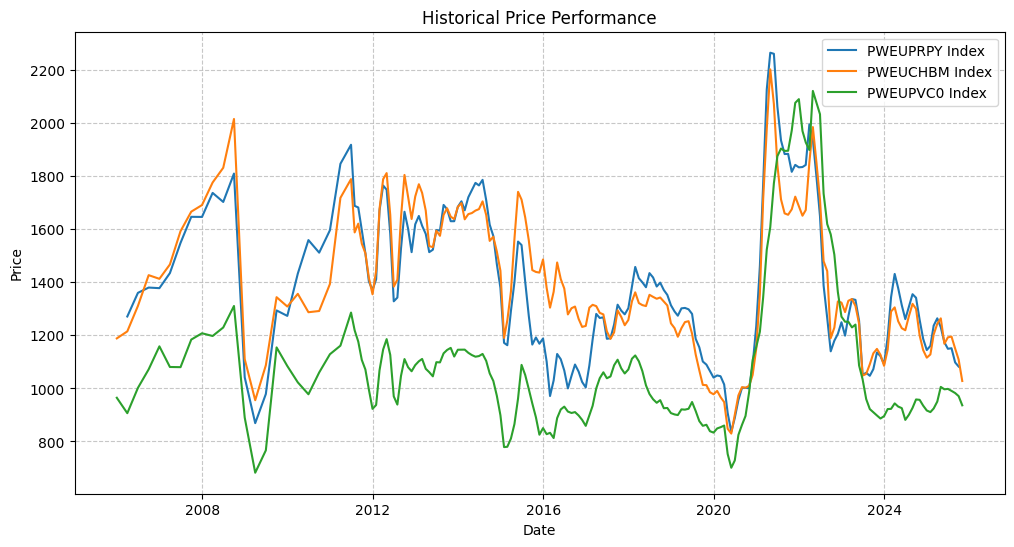


--- Simulation: PWEUPRPY Index ---
Current: 1082.37 | Long-term Mean: 1373.29
Forecast Mean (1yr): 1281.27
Prob < Threshold (1373.29): 65.41%


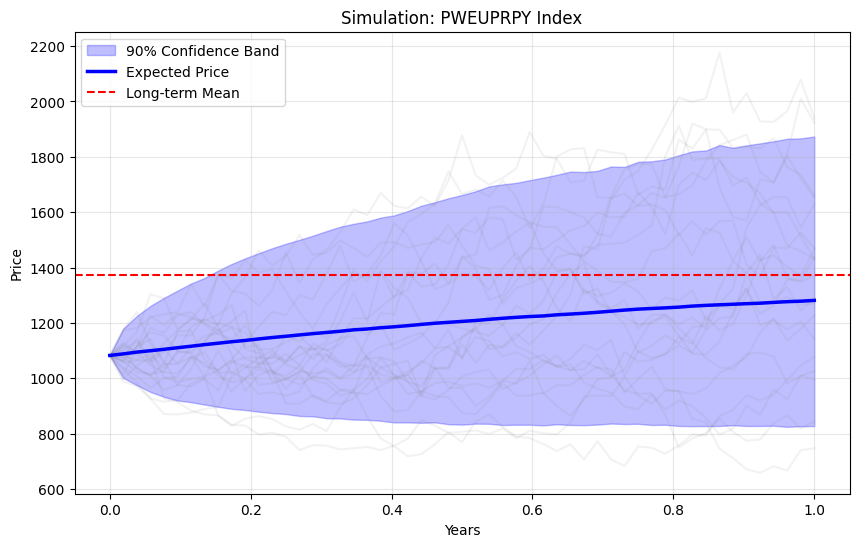


--- Simulation: PWEUCHBM Index ---
Current: 1027.95 | Long-term Mean: 1387.33
Forecast Mean (1yr): 1305.84
Prob < Threshold (1387.33): 64.14%


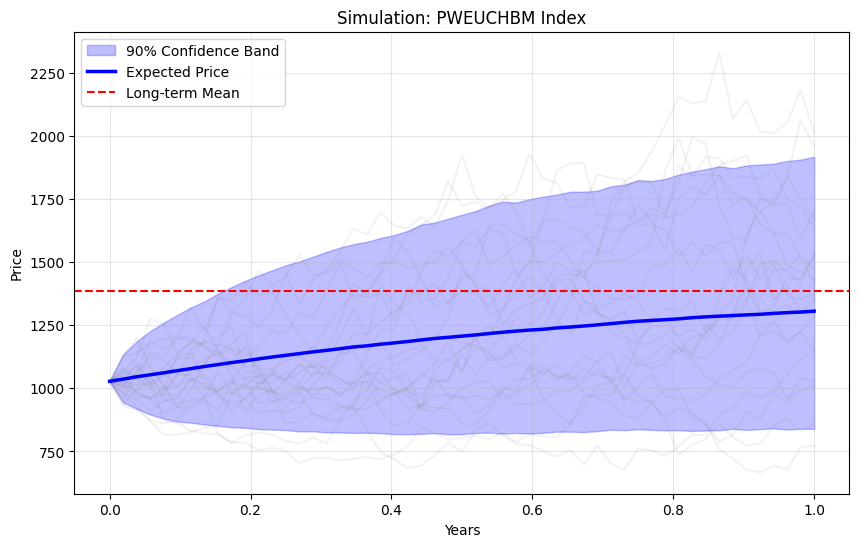


--- Simulation: PWEUPVC0 Index ---
Current: 936.22 | Long-term Mean: 1088.06
Forecast Mean (1yr): 1008.98
Prob < Threshold (1088.06): 66.98%


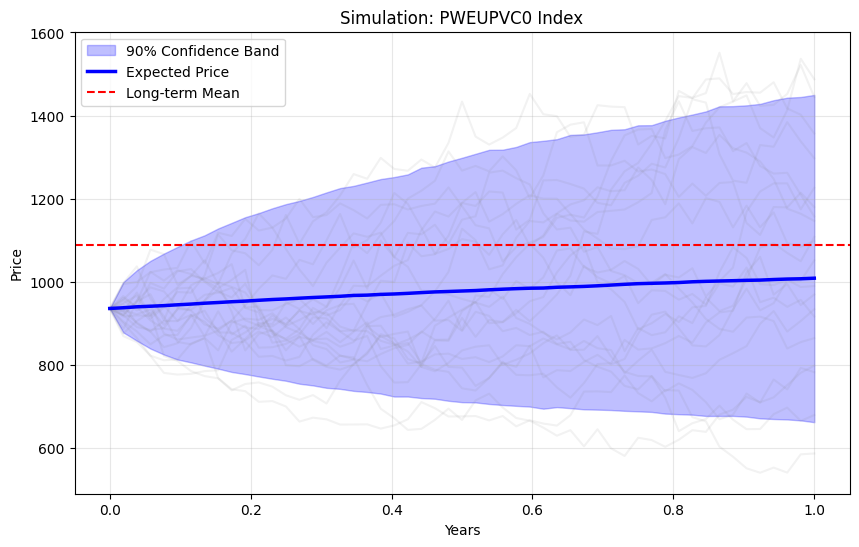

In [4]:
files = ["1.xlsx", "2.xlsx", "PVC.xlsx"]
securities_data = []
if __name__ == "__main__":
    for filename in files:
        try:
            meta = pd.read_excel(filename, nrows=1, header=None)
            name = meta.iloc[0, 1]
            df = pd.read_excel(filename, skiprows=6)
            df = df[['Date', 'PX_LAST']].copy()
            df['Date'] = pd.to_datetime(df['Date'])
            df['PX_LAST'] = pd.to_numeric(df['PX_LAST'], errors='coerce')
            df = df.dropna().sort_values('Date')
            securities_data.append({'name': name, 'df': df})
        except Exception as e:
            print(f"Could not load {filename}: {e}")
    if securities_data:
        plt.figure(figsize=(12, 6))
        for sec in securities_data:
            plt.plot(sec['df']['Date'], sec['df']['PX_LAST'], label=sec['name'])
        plt.title("Historical Price Performance")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
    for sec in securities_data:
        df = sec['df']
        name = sec['name']
        theta, mu, sigma = calibrate_ou_params(df)
        current_px = df['PX_LAST'].iloc[-1]
        simulate_log_ou_price(
            current_price=current_px,
            long_term_mean_price=mu,
            reversion_speed=theta,
            volatility_price=sigma,
            cheap_threshold=mu,
            title=f"Simulation: {name}"
        )